In [7]:
import os
import shutil
import glob

import cv2
import h5py
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

In [8]:
def mkdir_if_not_exist(dir_name, is_delete=False):
    try:
        if is_delete:
            if os.path.exists(dir_name):
                shutil.rmtree(dir_name)
                print(u'[INFO] Directory "%s" exists, deleting.' % dir_name)

        if not os.path.exists(dir_name):
            os.makedirs(dir_name)
            print(u'[INFO] Directory "%s" not exists, creating.' % dir_name)
        return True
    except Exception as e:
        print('[Exception] %s' % e)
        return False

def create_hdf5_and_checkpoint_folders(dataset_path):
    print("[INFO] Creating HDF5 and Checkpoint folders")
    hdf5_path = os.path.join(dataset_path, "hdf5/")
    checkpoint_path = os.path.join(dataset_path, "checkpoint/")
    mkdir_if_not_exist(hdf5_path)
    mkdir_if_not_exist(checkpoint_path)
    print("[INFO] Folders Created")

def write_hdf5(arr, outfile):
    with h5py.File(outfile, "w") as f:
        f.create_dataset("image", data=arr, dtype=arr.dtype)

def load_hdf5(infile):
    with h5py.File(infile, "r") as f:
        return f["image"][()]

In [9]:
create_hdf5_and_checkpoint_folders(dataset_path='./DRIVE')
create_hdf5_and_checkpoint_folders(dataset_path='./DRION-DB')

[INFO] Creating HDF5 and Checkpoint folders
[INFO] Folders Created
[INFO] Creating HDF5 and Checkpoint folders
[INFO] Folders Created


In [10]:
def normalize_color(image):

    image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)

    return image

In [11]:
def read_images(paths, INPUT_SIZE):
    
    images = []
    
    for path in paths:
        img = Image.open(path)
        img = img.resize((INPUT_SIZE, INPUT_SIZE))
        img = np.array(img)
        img = normalize_color(img)
        images.append(img)
    
    return images

def read_masks(paths, INPUT_SIZE):
    
    masks = []
    
    for path in paths:
        mask = Image.open(path).convert("L")
        mask = mask.resize((INPUT_SIZE, INPUT_SIZE))
        mask = np.array(mask)
        mask = mask / 255.
        mask[mask > 0.5] = 1
        mask[mask <= 0.5] = 0
        mask = mask.astype(np.float32)
        masks.append(mask)
    
    return masks
    
def load_data(path, INPUT_SIZE):
    images = sorted(glob.glob(os.path.join(path, "images/*")))
    masks = sorted(glob.glob(os.path.join(path, "groundtruth/*")))
    
    x = read_images(images, INPUT_SIZE)
    y = read_masks(masks, INPUT_SIZE)

    x = np.array(x)
    y = np.array(y)

    x = np.reshape(x, (len(x), INPUT_SIZE, INPUT_SIZE, 3))
    y = np.reshape(y, (len(y), INPUT_SIZE, INPUT_SIZE, 1))
    
    return (x, y)

def prepare_dataset(dataset_name, dataset_path, INPUT_SIZE):
    train_images, train_masks = load_data(os.path.join(dataset_path, "train/"), INPUT_SIZE)
    val_images, val_masks = load_data(os.path.join(dataset_path, "validate/"), INPUT_SIZE)
    print(f"[INFO] Saving {dataset_name} Training Data")
    write_hdf5(train_images, os.path.join(dataset_path, "hdf5/train_images.hdf5"))
    write_hdf5(train_masks, os.path.join(dataset_path, "hdf5/train_masks.hdf5"))
    print(f"[INFO] Saving {dataset_name} Validation Data")
    write_hdf5(val_images, os.path.join(dataset_path, "hdf5/val_images.hdf5"))
    write_hdf5(val_masks, os.path.join(dataset_path, "hdf5/val_masks.hdf5"))

In [12]:
prepare_dataset(dataset_name='DRIVE', dataset_path='./DRIVE', INPUT_SIZE=512)
prepare_dataset(dataset_name='DRION-DB', dataset_path='./DRION-DB', INPUT_SIZE=512)

[INFO] Saving DRIVE Training Data
[INFO] Saving DRIVE Validation Data
[INFO] Saving DRION-DB Training Data
[INFO] Saving DRION-DB Validation Data


In [13]:
def get_train_data(dataset_path):
    train_images = load_hdf5(dataset_path + '/hdf5/train_images.hdf5')
    train_masks = load_hdf5(dataset_path + '/hdf5/train_masks.hdf5')
    return train_images, train_masks

def get_validate_data(dataset_path):
    val_images = load_hdf5(dataset_path + '/hdf5/val_images.hdf5')
    val_masks = load_hdf5(dataset_path + '/hdf5/val_masks.hdf5')
    return val_images, val_masks

In [14]:
train_images, train_masks = get_train_data(dataset_path='./DRIVE')
val_images, val_masks = get_validate_data(dataset_path='./DRIVE')

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------
------------------TRAIN------------------
No. of Images: 232 || Masks: 232
Shape of Images: (232, 512, 512, 3) || Masks: (232, 512, 512, 1)
Type of Images: uint8 || Masks: float32
-----------------VALIDATE----------------
No. of Images: 4 || Masks: 4
Shape of Images: (4, 512, 512, 3) || Masks: (4, 512, 512, 1)
Type of Images: uint8 || Masks: float32 

----------------------------------Input Samples----------------------------------


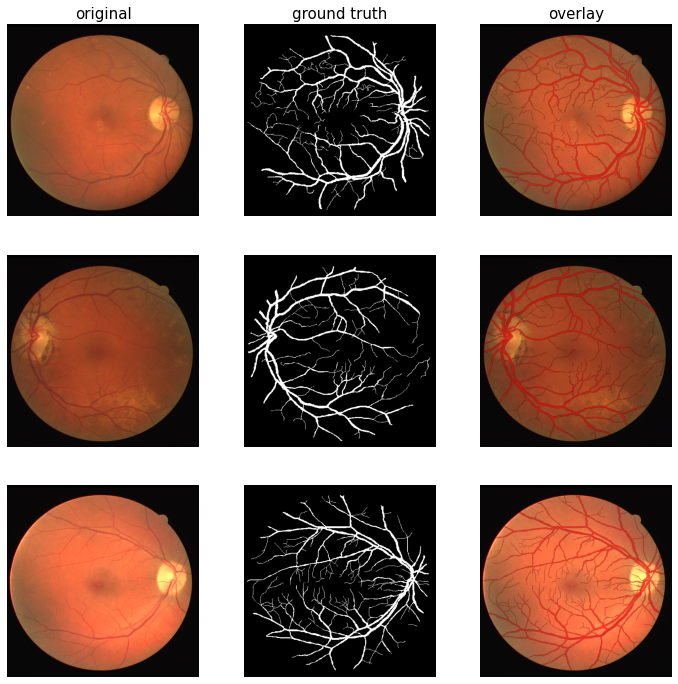

In [15]:
from keras_unet.utils import plot_imgs

print("------------------TRAIN------------------")
print(f"No. of Images: {len(train_images)} || Masks: {len(train_masks)}")
print(f"Shape of Images: {train_images.shape} || Masks: {train_masks.shape}")
print(f"Type of Images: {train_images.dtype} || Masks: {train_masks.dtype}") 

print("-----------------VALIDATE----------------")
print(f"No. of Images: {len(val_images)} || Masks: {len(val_masks)}")
print(f"Shape of Images: {val_images.shape} || Masks: {val_masks.shape}")
print(f"Type of Images: {val_images.dtype} || Masks: {val_masks.dtype} \n") 

print('----------------------------------Input Samples----------------------------------')
plot_imgs(org_imgs=train_images, mask_imgs=train_masks, pred_imgs=None, nm_img_to_plot=3, color="red")